A lot of this stuff hinges on having the right initial data. We cant run the agents at this moment. I Added the stuff here that was already in workshop 4, but like I said, it will not run.

Personally, I believe that we have to store the eventual data of every script in a csv file. This script needs a program of requirements.

Load Libraries

In [63]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import pandas as pd
import numpy as np
import functions
np.random.seed(0)

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

Define Stencil

In [64]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
stencil.set_index([0,0,0], 0)
print(stencil)

[[[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 1 0]
  [1 0 1]
  [0 1 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]]


Define the environment

In [65]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/meshes/voxelized_envelope_highres.csv')
avail_lattice = tg.lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)


load program (insert the program of requirements here)

In [66]:
#loading the relative relations excell

# relative_rels = pd.read_excel('../data/relationships/relative_relations.xlsx', index_col=0) 
# relative_rels_norm = relative_rels.div(relative_rels.sum(axis=1), axis=0)
# relative_rels_norm = relative_rels_norm.fillna(0)

#loading the relative preferences excell
relative_prefs = pd.read_excel('../data/relationships/relative_preferences.xlsx')
relative_prefs.iloc[:, 1:] = relative_prefs.iloc[:, 1:].div(relative_prefs.iloc[:, 1:].sum(axis=1), axis=0)
relative_prefs.iloc[:, 1:] = relative_prefs.iloc[:, 1:].fillna(0)
relative_prefs_norm = relative_prefs
relative_prefs_norm = relative_prefs_norm.head(3)

In [67]:
program_prefs = relative_prefs_norm.drop(["space_name", "facade_connection","penthouse_factor","street_sight", "noise_approval", "sunlight_access", "sky_view_factor", "football_field"], 1)
program_prefs

,proximity_to_ground_floor
0,0.000000
1,0.000000
2,0.181818


Load the value fields

In [68]:
# loading the lattice from csv
fields = {}
for f in program_prefs.columns:
    lattice_path = os.path.relpath('../data/fields/' + f + '.csv')
    fields[f] = tg.lattice_from_csv(lattice_path)

Initialize the agents

In [69]:
# initialize the occupation lattice
occ_lattice = avail_lattice * 0 - 1

# Finding the index of the available voxels in avail_lattice
avail_flat = avail_lattice.flatten()
avail_index = np.array(np.where(avail_lattice == 1)).T

# Randomly choosing three available voxels
agn_num = len(program_prefs)
np.random.seed()
select_id = np.random.choice(len(avail_index), agn_num)
agn_origins = avail_index[select_id]

# adding the origins to the agents locations
agn_locs = []
# for each agent origin ... 
for a_id, a_origin in enumerate(agn_origins):

    # add the origin to the list of agent locations
    agn_locs.append([a_origin])

    # set the origin in availablity lattice as 0 (UNavailable)
    avail_lattice[tuple(a_origin)] = 0

    # set the origin in occupation lattice as the agent id (a_id)
    occ_lattice[tuple(a_origin)] = a_id

printing the ammount of agents

In [70]:
print(a_id)

2


show the agents

In [71]:
p = pv.Plotter(notebook=True)

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(occ_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = occ_lattice.minbound - occ_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = occ_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#777777")

# Add the data values to the cell data
grid.cell_arrays["Agents"] = occ_lattice.flatten(order="F").astype(int)  # Flatten the array!
# filtering the voxels
threshed = grid.threshold([-0.1, agn_num - 0.9])
# adding the voxels
p.add_mesh(threshed, show_edges=True, opacity=1.0, show_scalar_bar=False)

# adding the availability lattice
init_avail_lattice.fast_vis(p)

p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(239.8279062084888, 147.3279062084888, 222.3279062084888),
 (35.0, -57.5, 17.5),
 (0.0, 0.0, 1.0)]

Run the simulation

In [72]:
# make a deep copy of occupation lattice
cur_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
# initialzing the list of frames
frames = [cur_occ_lattice]

# setting the time variable to 0
t = 0
n_frames = 30
# main feedback loop of the simulation (for each time step ...)
while t<n_frames:
    # for each agent ... 
    for a_id, a_prefs in relative_prefs_norm.iterrows():
        # retrieve the list of the locations of the current agent
        a_locs = agn_locs[a_id]
        # initialize the list of free neighbours
        free_neighs = []
        # for each location of the agent
        for loc in a_locs:
            # retrieve the list of neighbours of the agent based on the stencil
            neighs = avail_lattice.find_neighbours_masked(stencil, loc = loc)
            
            # for each neighbour ... 
            for n in neighs:
                # compute 3D index of neighbour
                neigh_3d_id = np.unravel_index(n, avail_lattice.shape)
                # if the neighbour is available... 
                if avail_lattice[neigh_3d_id]:
                    # add the neighbour to the list of free neighbours
                    free_neighs.append(neigh_3d_id)
        # check if found any free neighbour
        if len(free_neighs)>0:
            # convert free neighbours to a numpy array
            fns = np.array(free_neighs)

            # find the value of neighbours
            # init the agent value array
            a_eval = np.ones(len(fns))
            # for each field...
            for f in program_prefs.columns:
                # find the raw value of free neighbours...
                vals = fields[f][fns[:,0], fns[:,1], fns[:,2]]
                # raise the the raw value to the power of preference weight of the agent
                a_weighted_vals = vals ** a_prefs[f]
                # multiply them to the previous weighted values
                a_eval *= a_weighted_vals

            #post-processing
            functions.squareness(square_weight=0.9, free_neighs=free_neighs, a_eval=a_eval)


            # select the neighbour with highest evaluation
            selected_int = np.argmax(a_eval)
            # find 3D integer index of selected neighbour
            selected_neigh_3d_id = free_neighs[selected_int]
            # find the location of the newly selected neighbour
            selected_neigh_loc = np.array(selected_neigh_3d_id).flatten()
            # add the newly selected neighbour location to agent locations
            agn_locs[a_id].append(selected_neigh_loc)
            # set the newly selected neighbour as UNavailable (0) in the availability lattice
            avail_lattice[selected_neigh_3d_id] = 0
            # set the newly selected neighbour as OCCUPIED by current agent 
            # (-1 means not-occupied so a_id)
            occ_lattice[selected_neigh_3d_id] = a_id

    # constructing the new lattice
    new_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
    # adding the new lattice to the list of frames
    frames.append(new_occ_lattice)
    # adding one to the time counter
    t += 1

Visualize the result

In [73]:
p = pv.Plotter(notebook=True)

base_lattice = frames[0]

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the availability lattice
init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")

def create_mesh(value):
    f = int(value)
    lattice = frames[f]

    # Add the data values to the cell data
    grid.cell_arrays["Agents"] = lattice.flatten(order="F").astype(int)  # Flatten the array!
    # filtering the voxels
    threshed = grid.threshold([-0.1, agn_num - 0.9])
    # adding the voxels
    p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)

    return

p.add_slider_widget(create_mesh, [0, n_frames], title='Time', value=0, event_type="always", style="classic")
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(239.8279062084888, 147.3279062084888, 222.3279062084888),
 (35.0, -57.5, 17.5),
 (0.0, 0.0, 1.0)]

### Collecting Agent voxels

In [150]:
occupied_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)
occupied_lattice[occupied_lattice==1]=0

for i in range(len(agn_locs)):
    for loc in agn_locs[i]:
        occupied_lattice[tuple(loc)]=1

# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
occupied_lattice.fast_vis(p)

#p.add_mesh(tri_to_pv(combine_tractor), color='#FAE31D')

# plotting
p.show(use_ipyvtk=True)


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(239.8279062084888, 147.3279062084888, 222.3279062084888),
 (35.0, -57.5, 17.5),
 (0.0, 0.0, 1.0)]

In [147]:
def transformation_matrix (arr):
    return [[1,0,0,int(arr[0])],[0,1,0,int(arr[1])],[0,0,1,int(arr[2])],[0,0,0,1]]
# collecting voxel id of agent voxels
occ_id=np.array(np.where(occupied_lattice !=0 )).T

# collecting center points of voxels
env_cens = occ_lattice.centroids_threshold(-1)

# isolating the centroids of the agent voxels
env_cens1=env_cens[occ_id]

meshes = [tm.creation.box(extents=occupied_lattice.unit,transform=transformation_matrix(env_cens[i])) for i in range(len(env_cens))]
combine_tractor = tm.util.concatenate(meshes)


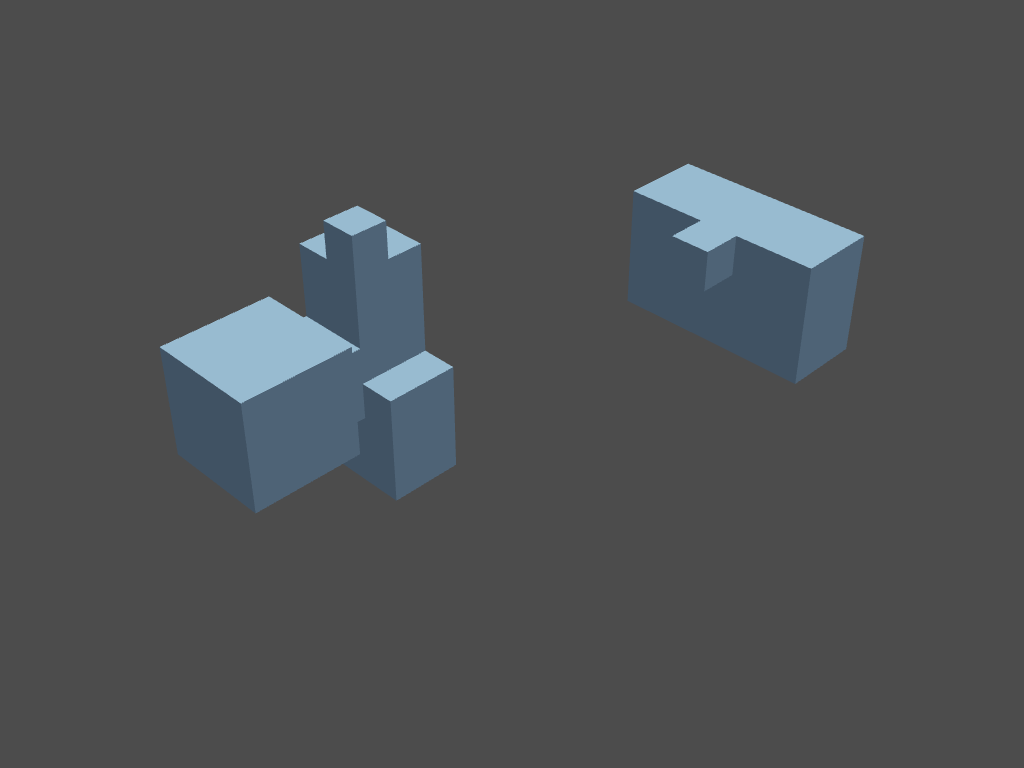

[(177.95901767327877, 42.95901767327875, 115.45901767327875),
 (82.5, -52.5, 20.0),
 (0.0, 0.0, 1.0)]

In [148]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# env_cens.fast_vis(p)
# adding the meshes
p.add_mesh(tri_to_pv(combine_tractor), color='#abd8ff')

# plotting
p.show()

### Collecting facade voxels

In [77]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
stencil.set_index([0,0,0], 0)
stencil.set_index([0,0,1], 0)
stencil.set_index([0,0,-1], 0)
stencil.function = tg.sfunc.sum
print(stencil)


[[[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 1 0]
  [0 0 0]
  [0 1 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]]


In [78]:
# collecting neighbours count for occupied lattice
occupied_lat_sten=occupied_lattice.apply_stencil(stencil)

facade_lattice=avail_lattice*0
# seperating the voxels with neighbours and excluding the occupied agents to retain only facade voxels
facade_lattice[occupied_lat_sten>0]=1
facade_lattice[occupied_lattice==1]=0


# extracting facade voxel centroids by excluding the envelope centers that are not facade voxels. 


### CONTINUE WORKING FROM HERE! The facade centroids is the issue, how to get those

In [90]:
# under is the facade_lattice containing a shape of (31,18,8) and size 4464 and a true sum of 121
# what I need is the centroids of those 121 voxels. 
facade_lattice.sum()


lattice(118)

In [159]:
# this is the centroids of all voxels in the latice regardless if they are false or true
fcd_cens=facade_lattice.centroids_threshold(-1)
# This collects the id of the voxels true as their value
fcd_id=np.array(np.where(facade_lattice == True )).T

print(fcd_cens)
print(fcd_id)
#print(fcd_cens1.shape)
# print(fcd_id)



[[ -40. -100.    0.]
 [ -40. -100.    5.]
 [ -40. -100.   10.]
 ...
 [ 110.  -15.   25.]
 [ 110.  -15.   30.]
 [ 110.  -15.   35.]]
[[18 10  5]
 [18 10  6]
 [18 10  7]
 [18 11  5]
 [18 11  6]
 [18 11  7]
 [18 12  5]
 [18 12  6]
 [18 12  7]
 [18 13  5]
 [18 13  6]
 [18 13  7]
 [18 14  5]
 [18 14  6]
 [18 14  7]
 [19  9  5]
 [19  9  6]
 [19  9  7]
 [19 15  5]
 [19 15  6]
 [19 15  7]
 [20  9  5]
 [20  9  6]
 [20  9  7]
 [20 15  5]
 [20 15  6]
 [20 15  7]
 [21 10  5]
 [21 10  6]
 [21 10  7]
 [21 11  5]
 [21 11  6]
 [21 11  7]
 [21 12  5]
 [21 12  6]
 [21 13  5]
 [21 13  6]
 [21 13  7]
 [21 14  5]
 [21 14  6]
 [21 14  7]
 [22 12  7]
 [24  5  1]
 [24  5  2]
 [24  5  3]
 [24  5  4]
 [24  5  5]
 [24  5  6]
 [24  6  1]
 [24  6  2]
 [24  6  3]
 [24  6  4]
 [24  6  5]
 [24  6  6]
 [24  7  1]
 [24  7  2]
 [24  7  3]
 [25  4  1]
 [25  4  2]
 [25  4  3]
 [25  4  4]
 [25  4  5]
 [25  4  6]
 [25  6  7]
 [25  7  4]
 [25  7  5]
 [25  7  6]
 [25  8  1]
 [25  8  2]
 [25  8  3]
 [26  4  1]
 [26  4  2]
 [26

In [158]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
fcd_cens.fast_vis(p)

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(231.22009113429812, 138.72009113429812, 213.72009113429812),
 (35.0, -57.5, 17.5),
 (0.0, 0.0, 1.0)]

In [143]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
# facade_lattice.fast_vis(p)
fcd_cens1.fast_vis(p)
p.add_mesh(tri_to_pv(combine_tractor), color='#FAE31D')

# plotting
p.show(use_ipyvtk=True)


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(229.17338297793367, 129.17338297793367, 211.67338297793367),
 (36.25, -63.75, 18.75),
 (0.0, 0.0, 1.0)]

### adding context mesh and street grid points

In [82]:
street_grid = os.path.relpath("../data/meshes/grid_points_2022.csv")
street_g = tg.cloud_from_csv(street_grid)
context_path = os.path.relpath('../data/meshes/immediate_context.obj')
context_mesh = tm.load(context_path)

context_mesh_complete=context_mesh+combine_tractor

### Putting it all together in a single visualization

In [83]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the street grid points
street_g.fast_vis(p)

# facade voxels
facade_lattice.fast_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh_complete), color='#aaaaaa')

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(785.8088446466429, 708.392439646643, 742.1697567966429),
 (65.08283250000001, -12.333572500000002, 21.44374465),
 (0.0, 0.0, 1.0)]

### extracting vector between facade centroid and street points

In [84]:
for i in range(len(facade_cens)):
    for f in range(len(street_g)):
        ray_dir=street_g[f]-facade_cens[i]
ray_dir

cloud([[121., -57., -35.],
       [131., -47., -25.],
       [131., -47., -25.]])

In [85]:
ray_dir_norm = ray_dir[5]/np.linalg.norm(ray_dir[5])

IndexError: index 5 is out of bounds for axis 0 with size 3